In [ ]:
# TMDB Multiprocess Fetcher - Google Colab Safe Version

import requests
import time
import json
import logging
import os
from datetime import datetime
from multiprocessing import Process
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')
SAVE_DIR = "/content/drive/MyDrive/tmdb_data"
os.makedirs(SAVE_DIR, exist_ok=True)

# Shared constants
BASE_URL = 'https://api.themoviedb.org/3'
IMAGE_BASE_URL = 'https://image.tmdb.org/t/p/w500'
REQUESTS_PER_10_SECONDS = 40
SECONDS_PER_WINDOW = 10
REQUEST_INTERVAL = SECONDS_PER_WINDOW / REQUESTS_PER_10_SECONDS

# Date ranges assigned to each process
DATE_RANGES = [
    ("2006-01-01", "2012-12-31"),
    ("2013-01-01", "2019-12-31"),
    ("2020-01-01", "2025-12-31")
]

API_KEYS = [
    '4c9f1b20ca0112fbc65112d04e968520',
    'c0bbd8a13de8f0ac309d5b9621920ba3',
    '752035b72485becd49355ff7fdb939de'
]

def setup_logging(process_id):
    log_path = os.path.join(SAVE_DIR, f"tmdb_process_{process_id}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log")
    logging.basicConfig(
        filename=log_path,
        level=logging.INFO,
        format="%(asctime)s - %(levelname)s - %(message)s"
    )

def rate_limit(request_count, window_start):
    request_count += 1
    elapsed = time.time() - window_start
    if request_count >= REQUESTS_PER_10_SECONDS:
        if elapsed < SECONDS_PER_WINDOW:
            time.sleep(SECONDS_PER_WINDOW - elapsed)
        request_count = 0
        window_start = time.time()
    else:
        time.sleep(REQUEST_INTERVAL)
    return request_count, window_start

def safe_request(url, params, api_key, request_count, window_start, retries=3):
    for _ in range(retries):
        params["api_key"] = api_key
        request_count, window_start = rate_limit(request_count, window_start)
        try:
            response = requests.get(url, params=params, timeout=10)
            if response.status_code == 200:
                return response, request_count, window_start
            elif response.status_code == 429:
                logging.warning("Rate limit hit (429). Waiting...")
                time.sleep(10)
            elif response.status_code == 502:
                logging.warning("502 Bad Gateway. Retrying...")
                time.sleep(5)
            else:
                logging.error(f"Request failed with status {response.status_code}")
        except requests.RequestException as e:
            logging.error(f"Request error: {e}")
        time.sleep(1)
    logging.error(f"All retries failed for URL: {url}")
    return None, request_count, window_start

def get_primary_genre(genres):
    return genres[0]['name'] if genres else None

def get_movies(start_date, end_date, page, api_key, request_count, window_start):
    url = f"{BASE_URL}/discover/movie"
    params = {
        "language": "en-US",
        "sort_by": "popularity.desc",
        "primary_release_date.gte": start_date,
        "primary_release_date.lte": end_date,
        "page": page
    }
    return safe_request(url, params, api_key, request_count, window_start)

def get_movie_details(movie_id, api_key, request_count, window_start):
    url = f"{BASE_URL}/movie/{movie_id}"
    params = {"language": "en-US"}
    response, request_count, window_start = safe_request(url, params, api_key, request_count, window_start)
    if response:
        data = response.json()
        return {
            "id": data.get("id"),
            "title": data.get("title"),
            "overview": data.get("overview"),
            "poster_url": IMAGE_BASE_URL + data["poster_path"] if data.get("poster_path") else None,
            "primary_genre": get_primary_genre(data.get("genres", []))
        }, request_count, window_start
    return None, request_count, window_start

def collect_movies(start_date, end_date, api_key, process_id):
    setup_logging(process_id)
    request_count = 0
    window_start = time.time()
    movies_data = []
    seen_ids = set()

    for page in range(1, 501):
        logging.info(f"[Process {process_id}] Fetching page {page}")
        print(f"[Process {process_id}] Fetching page {page}...")
        response, request_count, window_start = get_movies(start_date, end_date, page, api_key, request_count, window_start)
        if not response:
            break
        movies = response.json().get("results", [])
        if not movies:
            break
        for movie in movies:
            movie_id = movie["id"]
            if movie_id in seen_ids:
                continue
            details, request_count, window_start = get_movie_details(movie_id, api_key, request_count, window_start)
            if details:
                movies_data.append(details)
                seen_ids.add(movie_id)

    output_file = os.path.join(SAVE_DIR, f"tmdb_movies_{process_id}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(movies_data, f, indent=2)

    logging.info(f"[Process {process_id}] Saved {len(movies_data)} movies to {output_file}")
    print(f"[Process {process_id}] Done. Saved {len(movies_data)} movies to {output_file}")

def run_multiprocess():
    processes = []
    for i in range(len(API_KEYS)):
        start_date, end_date = DATE_RANGES[i]
        api_key = API_KEYS[i]
        p = Process(target=collect_movies, args=(start_date, end_date, api_key, i))
        processes.append(p)
        p.start()

    for p in processes:
        p.join()

if __name__ == "__main__":
    run_multiprocess()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[Process 1] Fetching page 1...[Process 0] Fetching page 1...

[Process 2] Fetching page 1...
[Process 0] Fetching page 2...
[Process 2] Fetching page 2...
[Process 1] Fetching page 2...
[Process 2] Fetching page 3...
[Process 0] Fetching page 3...
[Process 1] Fetching page 3...
[Process 2] Fetching page 4...
[Process 0] Fetching page 4...
[Process 1] Fetching page 4...
[Process 2] Fetching page 5...
[Process 0] Fetching page 5...
[Process 1] Fetching page 5...
[Process 2] Fetching page 6...
[Process 0] Fetching page 6...
[Process 1] Fetching page 6...
[Process 2] Fetching page 7...
[Process 0] Fetching page 7...
[Process 1] Fetching page 7...
[Process 0] Fetching page 8...
[Process 2] Fetching page 8...
[Process 1] Fetching page 8...
[Process 0] Fetching page 9...
[Process 2] Fetching page 9...
[Process 1] Fetching page 9...
[Process 0] Fetching page 10...
[P

In [ ]:
import json
import glob

# Find all the individual JSON files
file_paths = glob.glob("tmdb_movies_*.json")

all_movies = []
seen_ids = set()

for path in file_paths:
    with open(path, 'r', encoding='utf-8') as f:
        movies = json.load(f)
        for movie in movies:
            if movie["id"] not in seen_ids:
                all_movies.append(movie)
                seen_ids.add(movie["id"])

# Save to one combined JSON file
output_file = "tmdb_combined_movies.json"
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(all_movies, f, indent=2)

print(f"Merged {len(file_paths)} files with {len(all_movies)} unique movies into {output_file}")


Merged 6 files with 103212 unique movies into tmdb_combined_movies.json


In [ ]:
# reading the dataset
import json
import pandas as pd
df = pd.read_json("tmdb_combined_movies.json")
df.head()

,id,title,overview,poster_url,primary_genre
0,9355,Mad Max Beyond Thunderdome,Mad Max becomes a pawn in a decadent oasis of ...,https://image.tmdb.org/t/p/w500/jJlxcEVVUHnrUe...,Action
1,707,A View to a Kill,A newly-developed microchip designed by Zorin ...,https://image.tmdb.org/t/p/w500/arJF829RP9cYvh...,Adventure
2,1369,Rambo: First Blood Part II,John Rambo is released from prison by the gove...,https://image.tmdb.org/t/p/w500/pzPdwOitmTleVE...,Action
3,9846,To Live and Die in L.A.,When his longtime partner on the force is kill...,https://image.tmdb.org/t/p/w500/2iW3pSihBIhXjn...,Crime
4,9056,Police Story,Officer Chan Ka Kui manages to put a major Hon...,https://image.tmdb.org/t/p/w500/q8YfsyX59OmoSD...,Action


In [ ]:
# checking for dataset shape
print("Number of rows: ", df.shape[0])
print("Number of columns: ", df.shape[1])
# looking for redundant records
print("Number of duplicate records:", int(df.duplicated(keep = "first").sum()))

Number of rows:  103212
Number of columns:  5
Number of duplicate records: 0


Value Counts:
 primary_genre
Drama              16724
Documentary        12428
Comedy             11384
Animation          10596
Action             10316
Horror              9974
Thriller            3062
Music               3008
Romance             2515
Crime               2340
Family              1609
TV Movie            1522
Science Fiction     1497
Adventure           1376
Fantasy             1142
Mystery              923
History              473
War                  370
Western              199
Name: count, dtype: int64


<Axes: xlabel='primary_genre'>

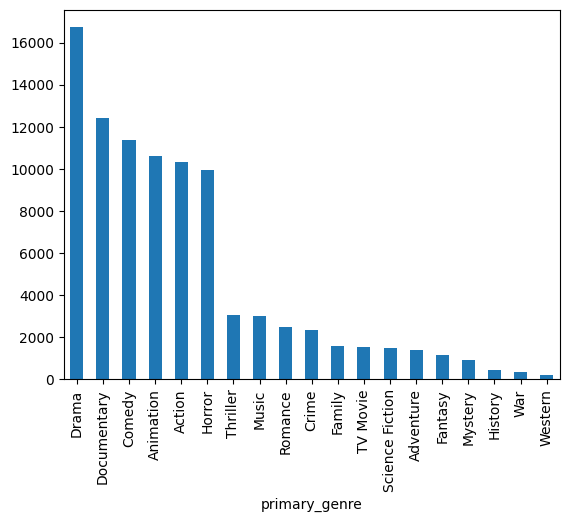

In [ ]:
# checking for value counts in primary_genre
print("Value Counts:\n", df["primary_genre"].value_counts())
df["primary_genre"].value_counts().plot(kind = "bar")

In [ ]:
genre_order = [
    'Documentary', 'Comedy', 'Animation', 'Horror', 'Thriller', 'Music', 'Romance', 'Crime',
    'Family', 'TV Movie', 'Science Fiction', 'Adventure', 'Fantasy', 'Mystery', 'History', 'War', 'Western'
]

# Find the index of 'Horror' and get all genres after it
horror_index = genre_order.index('Horror')
genres_after_horror = genre_order[horror_index + 1:]

# Replace genres after 'Horror' with 'Others'
df['primary_genre'] = df['primary_genre'].apply(lambda x: 'Others' if x in genres_after_horror else x)

Value Counts:
 primary_genre
Others         20036
Drama          16724
Documentary    12428
Comedy         11384
Animation      10596
Action         10316
Horror          9974
Name: count, dtype: int64


<Axes: xlabel='primary_genre'>

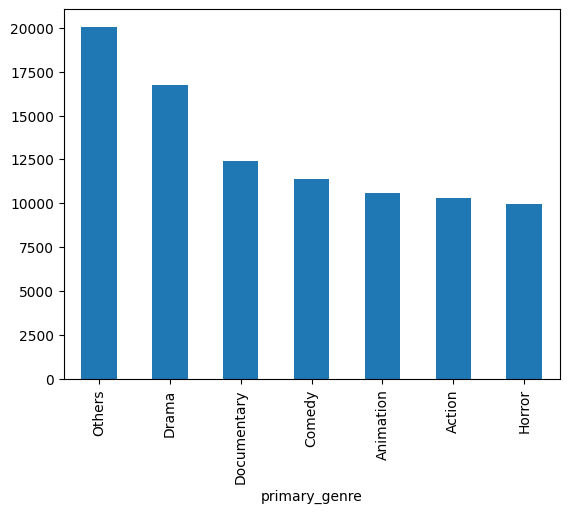

In [ ]:
# checking for value counts in primary_genre
print("Value Counts:\n", df["primary_genre"].value_counts())
df["primary_genre"].value_counts().plot(kind = "bar")

In [ ]:
output_file = os.path.join(SAVE_DIR, f"tmdb_movies_combined_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
df.to_json(output_file, orient="records", indent=2)
print(f"Saved modified data to {output_file}")

Saved modified data to /content/drive/MyDrive/tmdb_data/tmdb_movies_combined_20250503_191417.json


In [ ]:
df = pd.read_json("tmdb_combined_movies.json")
df.head()

,id,title,overview,poster_url,primary_genre
0,9355,Mad Max Beyond Thunderdome,Mad Max becomes a pawn in a decadent oasis of ...,https://image.tmdb.org/t/p/w500/jJlxcEVVUHnrUe...,Action
1,707,A View to a Kill,A newly-developed microchip designed by Zorin ...,https://image.tmdb.org/t/p/w500/arJF829RP9cYvh...,Adventure
2,1369,Rambo: First Blood Part II,John Rambo is released from prison by the gove...,https://image.tmdb.org/t/p/w500/pzPdwOitmTleVE...,Action
3,9846,To Live and Die in L.A.,When his longtime partner on the force is kill...,https://image.tmdb.org/t/p/w500/2iW3pSihBIhXjn...,Crime
4,9056,Police Story,Officer Chan Ka Kui manages to put a major Hon...,https://image.tmdb.org/t/p/w500/q8YfsyX59OmoSD...,Action


Value Counts:
 primary_genre
Drama              16724
Documentary        12428
Comedy             11384
Animation          10596
Action             10316
Horror              9974
Thriller            3062
Music               3008
Romance             2515
Crime               2340
Family              1609
TV Movie            1522
Science Fiction     1497
Adventure           1376
Fantasy             1142
Mystery              923
History              473
War                  370
Western              199
Name: count, dtype: int64


<Axes: xlabel='primary_genre'>

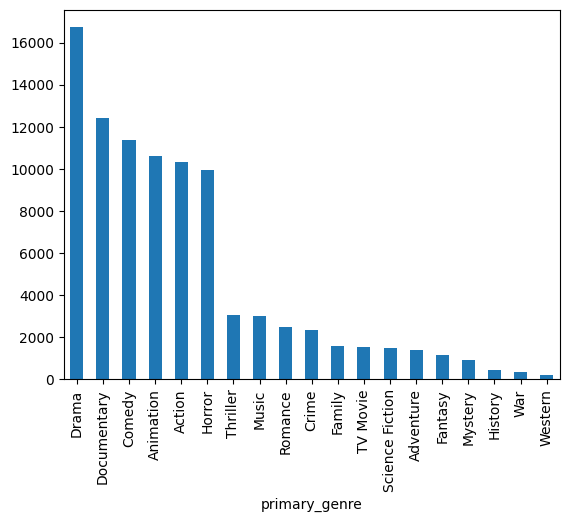

In [ ]:
# checking for value counts in primary_genre
print("Value Counts:\n", df["primary_genre"].value_counts())
df["primary_genre"].value_counts().plot(kind = "bar")

In [ ]:
genre_order = [
    'Documentary', 'Comedy', 'Animation', 'Horror', 'Thriller', 'Music', 'Romance', 'Crime',
    'Family', 'TV Movie', 'Science Fiction', 'Adventure', 'Fantasy', 'Mystery', 'History', 'War', 'Western'
]

# Find the index of 'Horror' and get all genres after it
horror_index = genre_order.index('Horror')
genres_after_horror = genre_order[horror_index + 1:]

# Replace genres after 'Horror' with 'Others'
df['primary_genre'] = df['primary_genre'].apply(lambda x: 'Others' if x in genres_after_horror else x)

Value Counts:
 primary_genre
Others         20036
Drama          16724
Documentary    12428
Comedy         11384
Animation      10596
Action         10316
Horror          9974
Name: count, dtype: int64


<Axes: xlabel='primary_genre'>

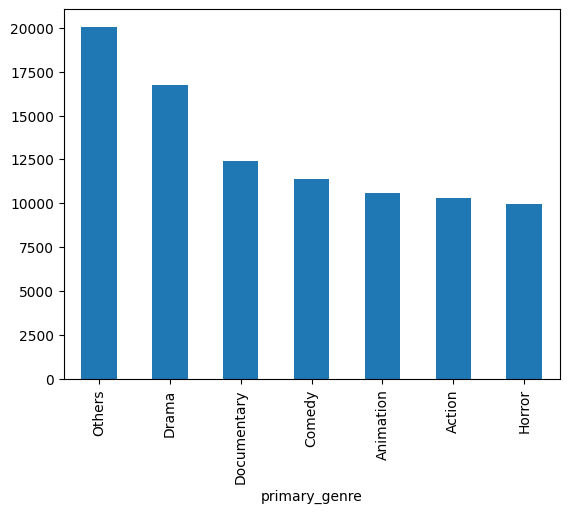

In [ ]:
# checking for value counts in primary_genre
print("Value Counts:\n", df["primary_genre"].value_counts())
df["primary_genre"].value_counts().plot(kind = "bar")

In [ ]:
output_file = os.path.join(SAVE_DIR, f"tmdb_movies_combined_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")
df.to_json(output_file, orient="records", indent=2)
print(f"Saved modified data to {output_file}")

Saved modified data to /content/drive/MyDrive/tmdb_data/tmdb_movies_combined_20250503_191718.json
